# Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

In [47]:
#Importing all the relevant packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np




from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [48]:
df= pd.read_csv("diabetes.csv")

Understanding the Data

- Preview the first 5 rows of the dataset
- Understanding the data by descriptive statistics
- Using a histogram to view the dispersion of the data

In [49]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [51]:
df.columns[2:3].values.tolist()

['BloodPressure']

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


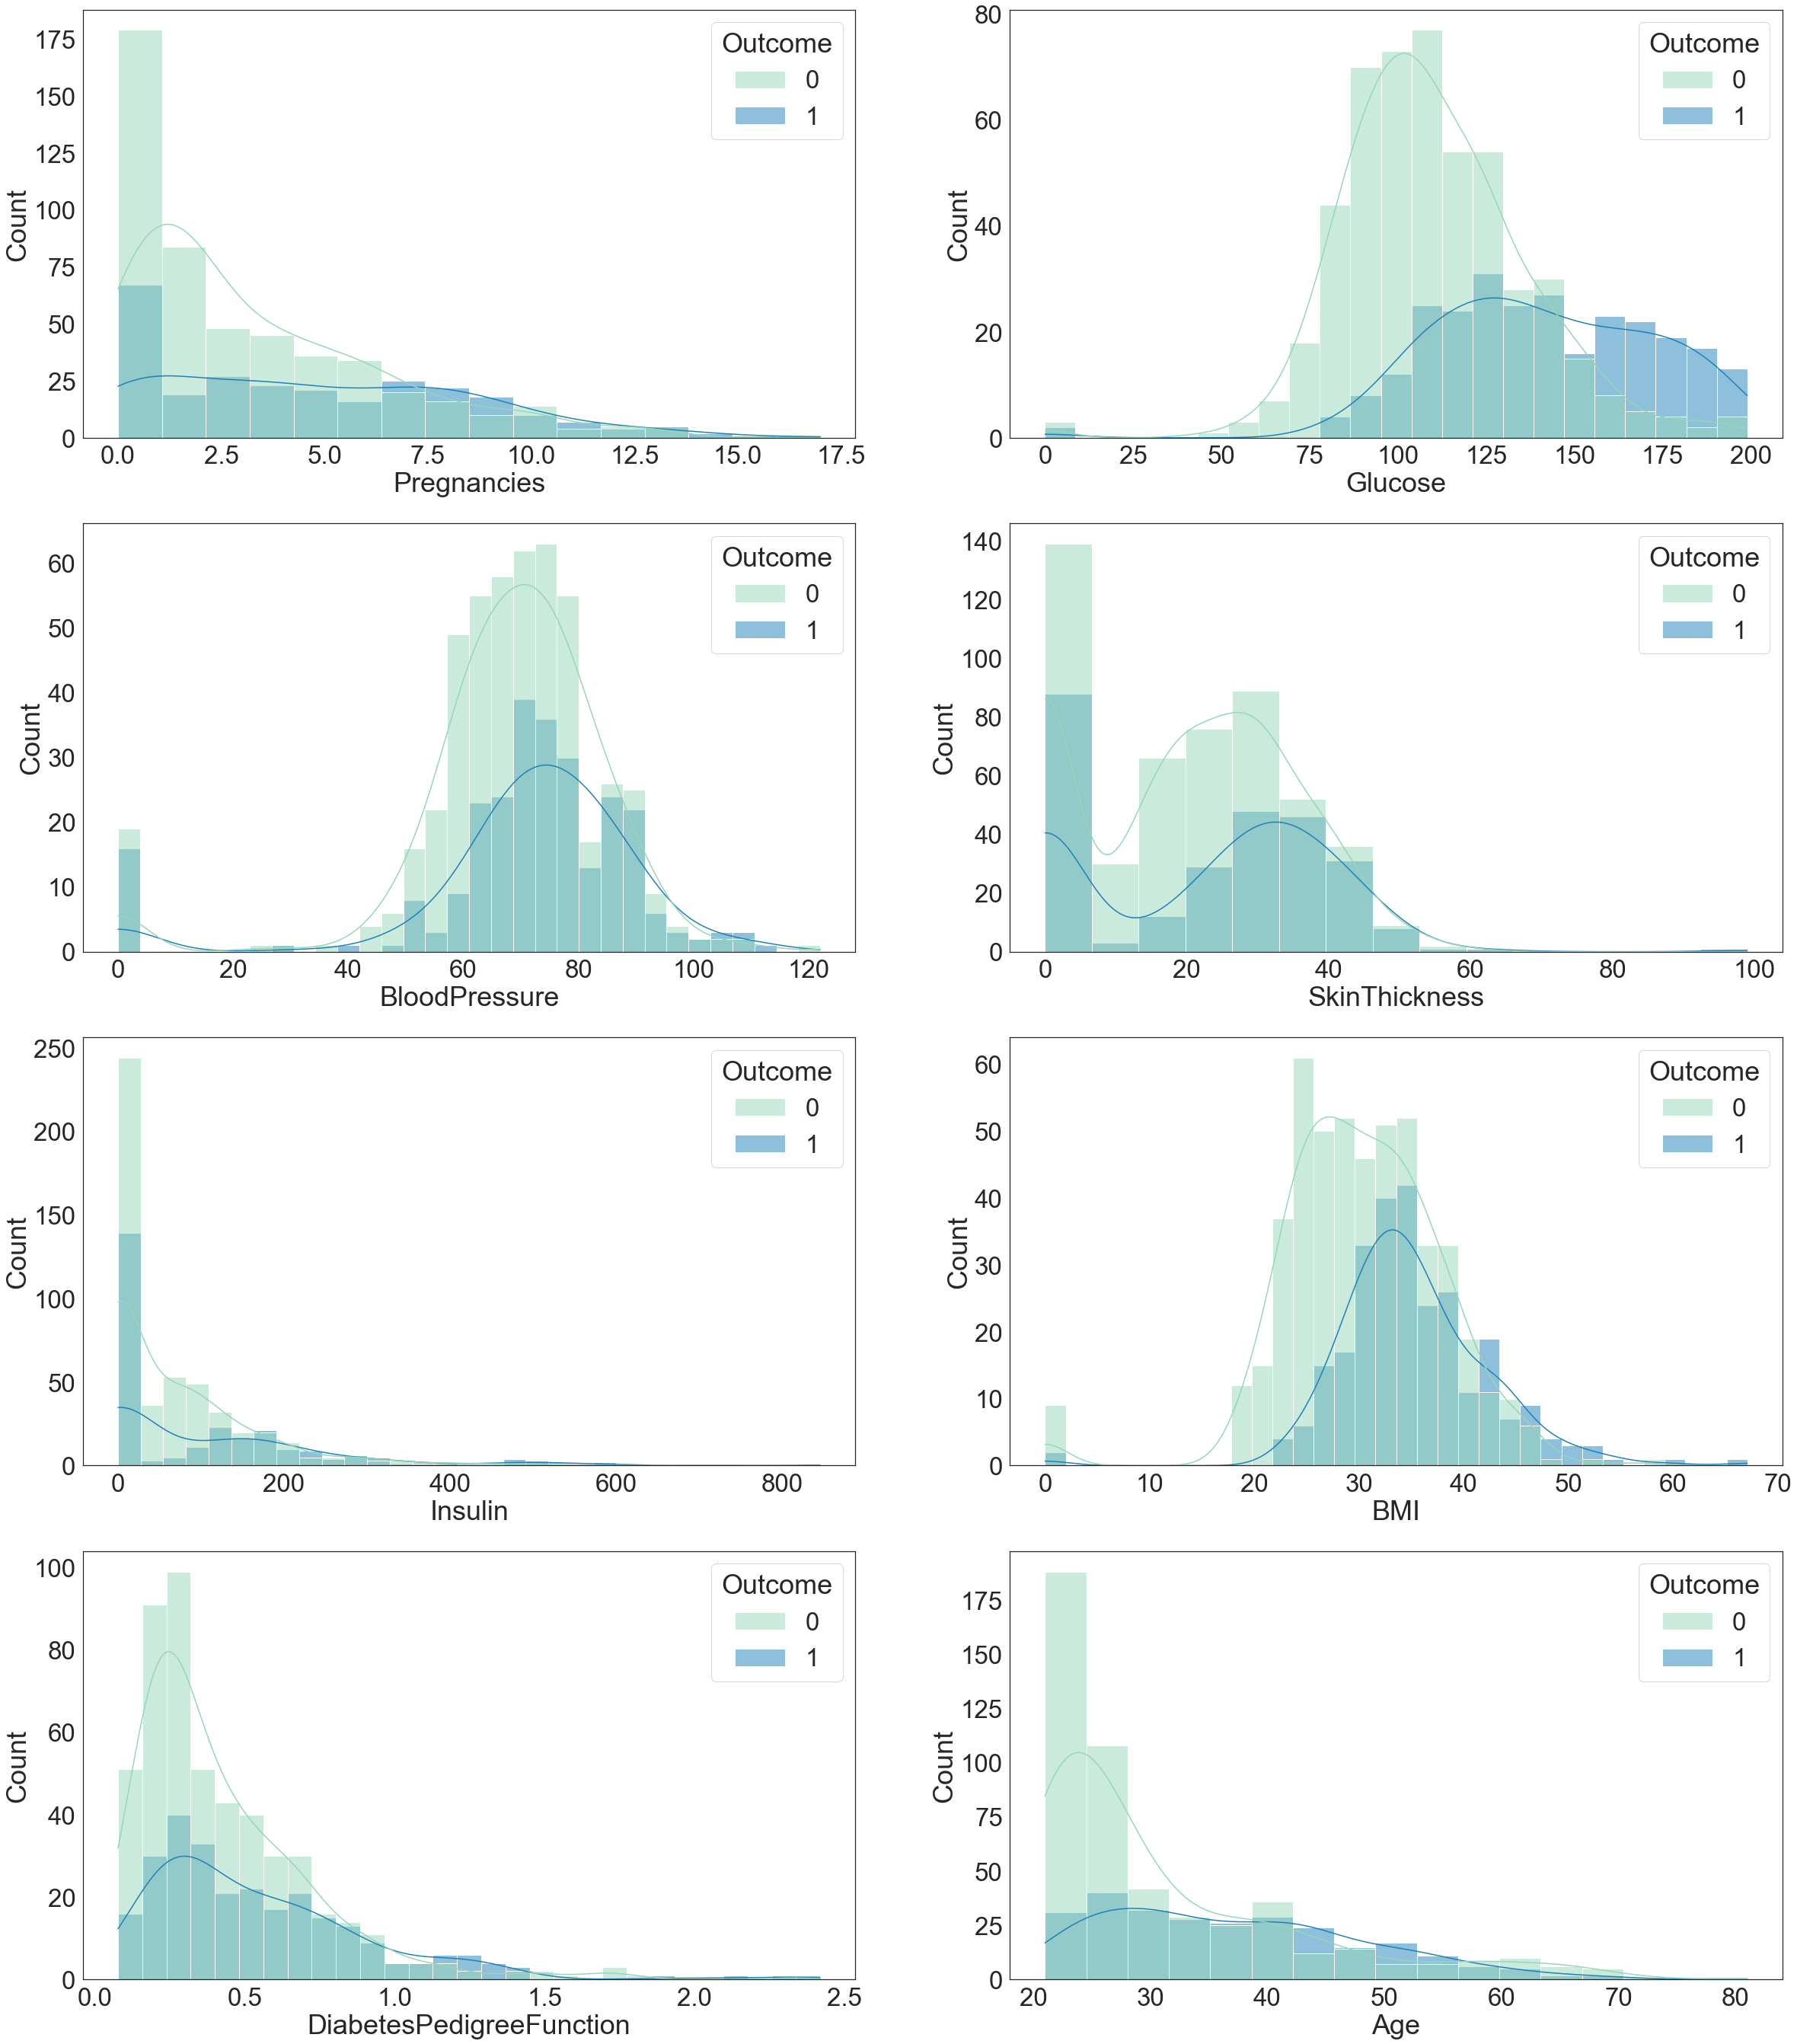

In [52]:
feature_names = df.drop(columns= 'Outcome').columns.values.tolist()
print(feature_names)

plt.rcParams['figure.figsize'] = 40, 60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.2)
i= 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i+= 1

- From the histogram, we can identify that there are several 0s that won't make sense in columns like Glucose, BloodPressure, SkinThickness, Insulin and BMI. These 0s will be replace as Nan.

- We will then identify how many missing values are there.
- These missing values will be replaced by the median values grouped by Outcome.

In [7]:
replace_nan= ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[replace_nan] =df[replace_nan].replace(0, np.NaN)

In [8]:
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [9]:
df= df.fillna(df.groupby('Outcome').transform('median'))
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
df.groupby(['Outcome'])['Glucose'].median()

Outcome
0    107.0
1    140.0
Name: Glucose, dtype: float64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.677083,30.464161,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.389323,12.106039,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.089844,8.890820,7.000,25.00000,28.0000,32.00000,99.00
Insulin,768.0,141.753906,89.100847,14.000,102.50000,102.5000,169.50000,846.00
BMI,768.0,32.434635,6.880498,18.200,27.50000,32.0500,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


- Identifying which columns have outliers by 1.5xIQR from its quartile range.
- These outliers are removed from the dataset

In [12]:
for feature in df:
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(("%s: %s (%f), Max: %f" % (feature, 'Yes', upper, df[feature].max())))
    else:
        print(("%s: %s ; Min: %f" % (feature, 'No', df[feature].min())))
    df.drop(df[(df[feature] > upper)].index, inplace= True)

Pregnancies: Yes (13.500000), Max: 17.000000
Glucose: No ; Min: 44.000000
BloodPressure: Yes (104.000000), Max: 122.000000
SkinThickness: Yes (42.500000), Max: 99.000000
Insulin: Yes (270.000000), Max: 846.000000
BMI: Yes (48.075000), Max: 57.300000
DiabetesPedigreeFunction: Yes (1.148000), Max: 2.288000
Age: Yes (64.000000), Max: 81.000000
Outcome: No ; Min: 0.000000


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,613.0,3.765090,3.211034,0.000,1.000,3.000,6.000,13.000
Glucose,613.0,116.944535,28.153585,44.000,97.000,112.000,132.000,196.000
BloodPressure,613.0,71.395595,11.026988,24.000,64.000,72.000,78.000,104.000
SkinThickness,613.0,27.494290,7.172846,7.000,24.000,27.000,32.000,42.000
Insulin,613.0,120.864600,45.229304,15.000,102.500,102.500,169.500,270.000
BMI,613.0,31.391354,6.138532,18.200,26.800,31.200,35.200,47.900
DiabetesPedigreeFunction,613.0,0.415197,0.238572,0.078,0.236,0.343,0.565,1.144
Age,613.0,32.027732,10.429543,21.000,24.000,28.000,39.000,64.000
Outcome,613.0,0.306688,0.461495,0.000,0.000,0.000,1.000,1.000


Visualising the distribution of the Outcome with a chart

In [14]:
data= df['Outcome'].value_counts()
data= data.rename(index={0: 'No Diabetes', 1:'Diabetes'})
print(data)

No Diabetes    425
Diabetes       188
Name: Outcome, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

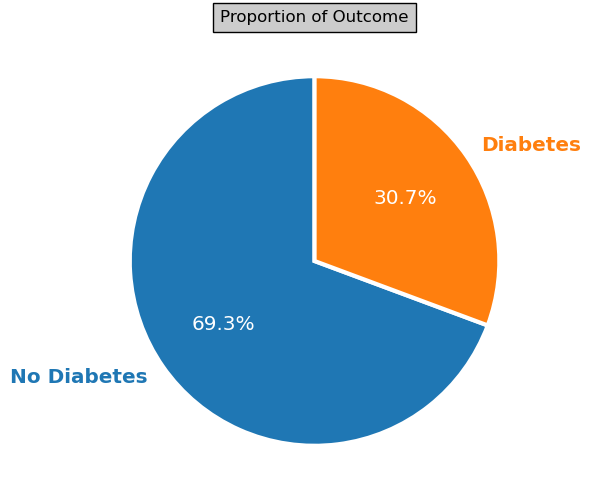

In [15]:
%matplotlib inline

sns.reset_defaults()
fig, ax = plt.subplots(figsize=(6, 6))
patches, texts, pcts = ax.pie(data, labels= data.index, autopct='%1.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)

for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())

plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
plt.title("Proportion of Outcome",  bbox={'facecolor':'0.8', 'pad':5})
plt.show


Understanding the correlation between all the variables

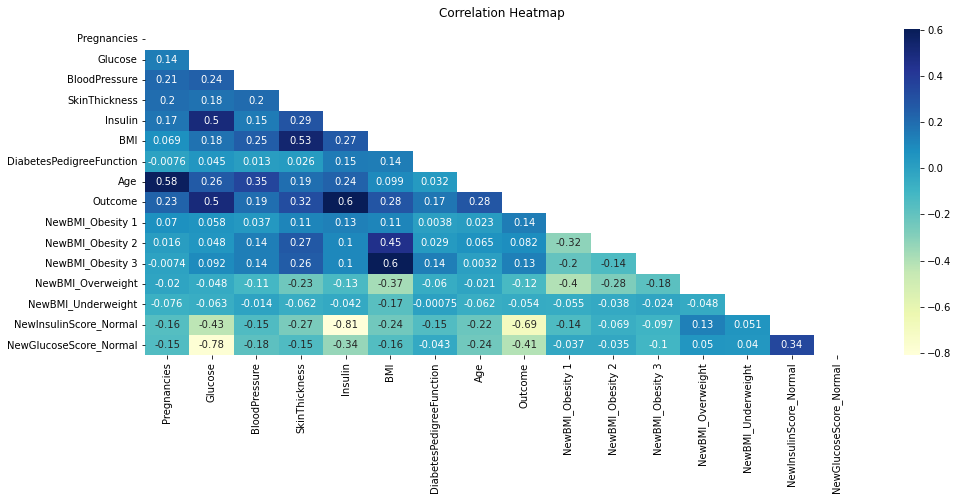

In [44]:
%matplotlib inline
#Visualising the correlation with heatmap

corr= df.corr()
plt.figure(figsize=(16, 6))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap="YlGnBu",mask=mask, annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Visualising variables highly related to Outcome on a Pairplot

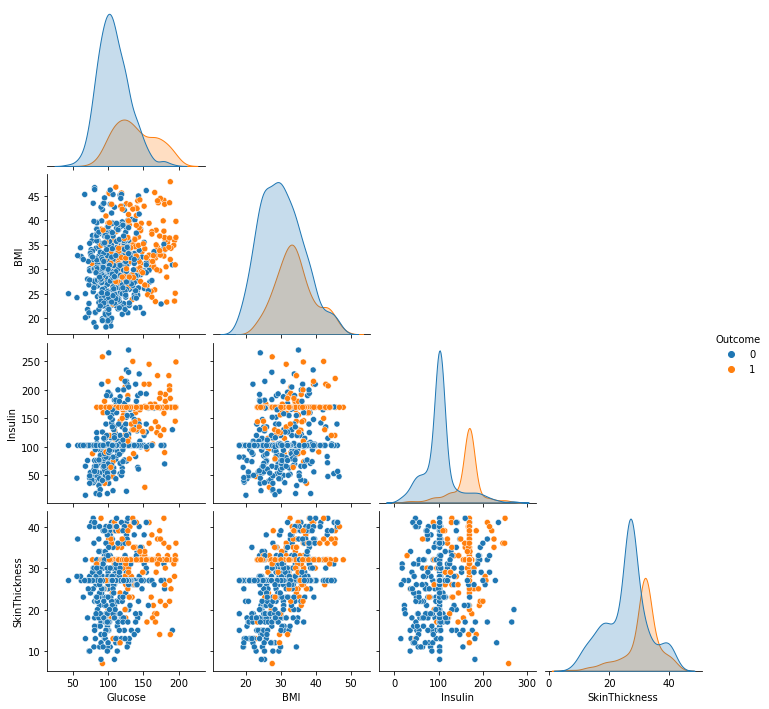

In [45]:
sns.pairplot(df,vars= ['Glucose', 'BMI','Insulin', 'SkinThickness'], hue= 'Outcome', corner= True)

Listing the number of patients that have increased level of Glucose, BMI and BloodPressure

In [18]:
x=  ('Glucose', 'BMI', 'BloodPressure')
y= [140, 28, 80]
z= ('High Blood Glucose', 'Obesity', 'Hypertensive')
def condition_list(df_column, cutoff, label):
    def check_condition(c,v, condition):
        n=0
        for variable in c:
            if variable> v:
                n+= 1
            else:
                n+= 0
        print("There are " + str(n) + " patients with " + condition)

    main_condition= df[df_column]
    check_condition(main_condition, cutoff, label)
for df_column, cutoff, label  in zip(x,y,z):
    condition_list(df_column, cutoff, label)

There are 114 patients with High Blood Glucose
There are 417 patients with Obesity
There are 110 patients with Hypertensive


- Feature Engineering 
- Assigning BMI, Insulin, and Glucose to its respective categories

In [19]:
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]

df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight
5,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0,Overweight


In [20]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal" 
df["NewInsulinScore"] = df.apply(set_insulin, axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Abnormal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal
5,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0,Overweight,Normal


In [21]:
def set_glucose(row):
    if row["Glucose"] >= 140 :
        return "Abnormal"
    else:
        return "Normal" 
df["NewGlucoseScore"] = df.apply(set_glucose, axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore,NewGlucoseScore
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal,Abnormal
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Abnormal,Abnormal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal,Normal
5,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0,Overweight,Normal,Normal


After creating new columns assigning categories, One-hot encoding is created.

In [22]:
df = pd.get_dummies(df, columns =["NewBMI","NewInsulinScore", "NewGlucoseScore"], drop_first = True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucoseScore_Normal
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,1,0,0,0,0,0,0
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,0,0,0,1,0,1,1
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,0,0,0,0,0,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0,1,0,1,1
5,5,116.0,74.0,27.0,102.5,25.6,0.201,30,0,0,0,0,1,0,1,1


Independent variables are seperated from newly created one hot encodings for standardization using StandardScaler

In [23]:
cut_columns= df.columns[8:].values.tolist()

one_hot= (df[cut_columns]).drop(['Outcome'], axis=1)
X= df.drop(cut_columns, axis= 1)
y= df['Outcome']

In [24]:
cols = X.columns
index = X.index

from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

After feature standardiization, independent variables are concatenated with the one hot encodings

In [25]:
X = pd.concat([X, one_hot], axis = 1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucoseScore_Normal
0,0.696578,1.103974,0.054856,1.047261,1.076185,0.360094,0.888517,1.724615,1,0,0,0,0,0,0
1,-0.861824,-1.135579,-0.489708,0.210089,-0.406365,-0.781175,-0.269310,-0.098621,0,0,0,1,0,1,1
2,1.319939,2.348170,-0.671229,0.628675,1.076185,-1.319202,1.077293,-0.002661,0,0,0,0,0,0,0
3,-0.861824,-0.993385,-0.489708,-0.627082,-0.594450,-0.536617,-1.041194,-1.058219,0,0,0,1,0,1,1
5,0.384897,-0.033577,0.236377,-0.068968,-0.406365,-0.944213,-0.898563,-0.194581,0,0,0,1,0,1,1


- Testing different models and obtaining the mean cross validation score of all models
- Comparing the scores between models using a boxplot

LR: 0.880883 (0.031907)
KNN: 0.889053 (0.036401)
CART: 0.871179 (0.034445)
RF: 0.898889 (0.021403)
SVM: 0.889080 (0.025023)
XGB: 0.902115 (0.029334)
LightGBM: 0.907033 (0.025232)


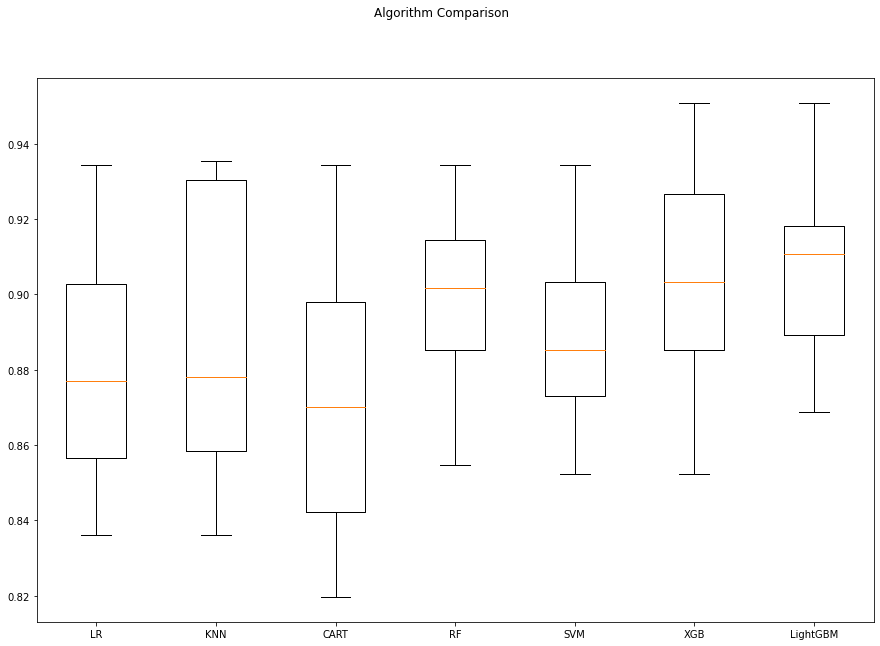

In [26]:
#listing all the models for test
models = []
models.append(('LR', LogisticRegression(random_state = 12345)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state = 12345)))
models.append(('RF', RandomForestClassifier(random_state = 12345)))
models.append(('SVM', SVC(gamma='auto', random_state = 12345)))
models.append(('XGB', GradientBoostingClassifier(random_state = 12345)))
models.append(("LightGBM", LGBMClassifier(random_state = 12345)))

results = []
names = []

#perform cross validation on all the models
for name, model in models:
    
    kfold = KFold(n_splits = 10)
        
    cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
        
#visualising the cross validation score on boxplot
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Model Optimisation

- From the estimated scores of all the models, we find that RandomForest, GradientBoosting and LGMBC were top 3 performing models.
- We will then optimise these top models to obtain the best parameters

##### Random Forest

In [27]:
#listing all the possible parameters for optimisation of the model
rf_params = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
            "max_depth": [3,5,8,None]}

rf_model = RandomForestClassifier(random_state = 12345)

rf_gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = 10,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [28]:
#the best optimised parameters for the model
rf_gs_cv.best_params_

{'max_depth': 8,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 500}

In [29]:
#the mean cross validation score of this model
rf_tuned = RandomForestClassifier(**rf_gs_cv.best_params_)
rf_tuned = rf_tuned.fit(X,y)
cross_val_score(rf_tuned, X, y, cv = 10).mean()

0.9054204124801692

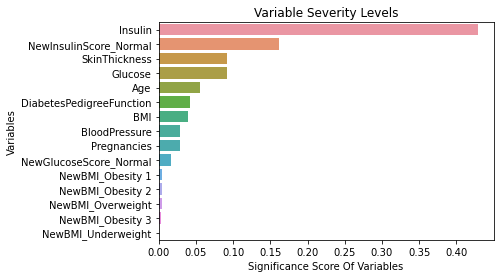

In [30]:
#Listing the most important features based on the model
feature_imp = pd.Series(rf_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

#### Light Gradient-Boosting Machine (LGBM)

In [31]:
#listing all the possible parameters for optimisation of the model
lgbm = LGBMClassifier(random_state = 12345)

lgbm_params = {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.5],
              "n_estimators": [500, 1000, 1500],
              "max_depth":[3,5,8]}

lgbm_gs_cv = GridSearchCV(lgbm, 
                     lgbm_params, 
                     cv = 10, 
                     n_jobs = -1, 
                     verbose = 2).fit(X, y)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


In [32]:
#the best optimised parameters for the model
lgbm_gs_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}

In [33]:
#the mean cross validation score of this model
lgbm_tuned = LGBMClassifier(**lgbm_gs_cv.best_params_).fit(X,y)
cross_val_score(lgbm_tuned, X, y, cv = 10).mean()

0.9135642517186675

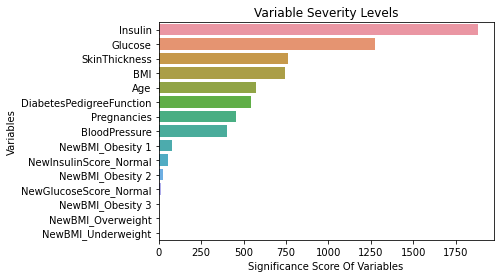

In [34]:
#Listing the most important features based on the model
feature_imp = pd.Series(lgbm_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

#### XGBoost

In [35]:
#listing all the possible parameters for optimisation of the model
xgb = GradientBoostingClassifier(random_state = 12345)

xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [100,1000]}
    
xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X, y)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


In [36]:
#the best optimised parameters for the model
xgb_cv_model.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_split': 0.4111111111111111,
 'n_estimators': 100,
 'subsample': 0.5}

In [37]:
#the mean cross validation score of this model
xgb_tuned = GradientBoostingClassifier(**xgb_cv_model.best_params_).fit(X,y)
cross_val_score(xgb_tuned, X, y, cv = 10).mean()

0.9053675304071918

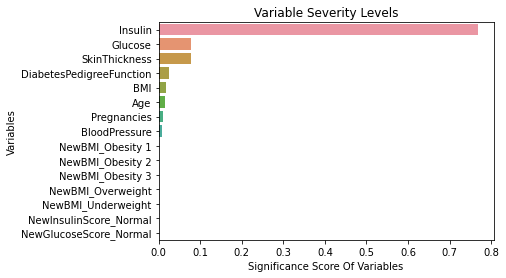

In [38]:
#Listing the most important features based on the model
feature_imp = pd.Series(xgb_tuned.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Significance Score Of Variables')
plt.ylabel('Variables')
plt.title("Variable Severity Levels")
plt.show()

- With the optimised parameters of each models, each models are tested and obtaining the mean cross validation score of top 3 models

- The mean cross validation score is compared with boxplot

In [39]:
#selecting model with the optimised parameters
models = []

models.append(( 'RF', RandomForestClassifier( max_depth = 8,  max_features = 7,  min_samples_split = 2,\
                                             n_estimators = 500)))
models.append(( 'XGB' , GradientBoostingClassifier( learning_rate = 0.1,\
                                                  max_depth = 3, min_samples_split = 0.4111111111111111,\
                                                  n_estimators = 100, subsample = 0.5)))
models.append(("LightGBM", LGBMClassifier( learning_rate = 0.01,  max_depth = 5,  n_estimators = 500)))

# evaluate each model in turn
results = []
names = []

RF: 0.905447 (0.024886)
XGB: 0.907033 (0.038486)
LightGBM: 0.913564 (0.017879)


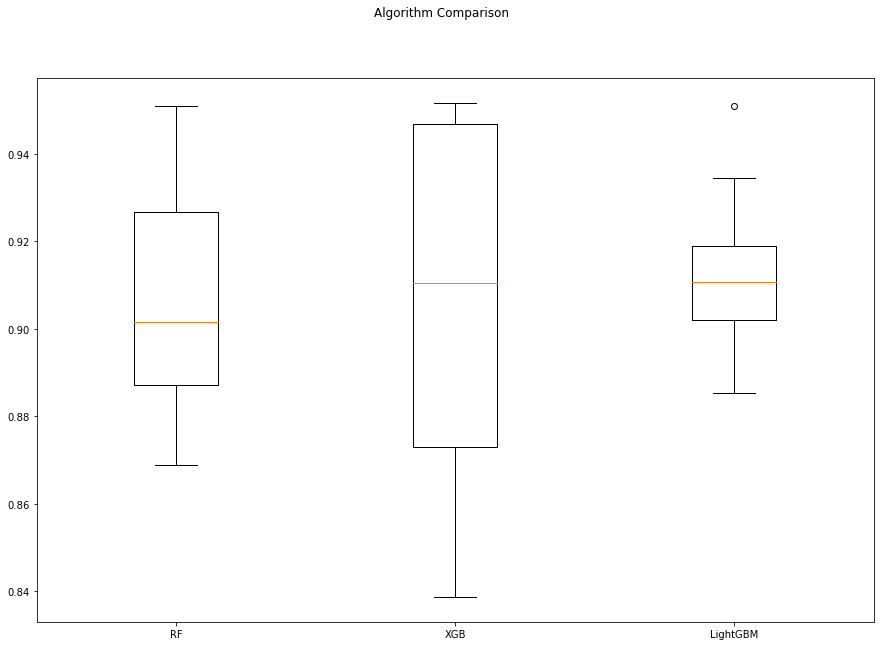

In [40]:
#Listing the mean cross validation score of each model
for name, model in models:
    
        kfold = KFold(n_splits = 10)
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()